# 05 — Regression Tree Notebook
- Get CCP path, CV over ccp_alpha, select min-CV, evaluate on test


In [42]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [44]:
# local utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from utils_plots import plot_pred_vs_actual, plot_residuals, report_mse

# load train/test data
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_path = os.path.join(DATA_DIR, 'concrete_train.csv')
test_path  = os.path.join(DATA_DIR, 'concrete_test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

X_train = train_df.drop(columns=['concrete_compressive_strength'])
y_train = train_df['concrete_compressive_strength'].values
X_test  = test_df.drop(columns=['concrete_compressive_strength'])
y_test  = test_df['concrete_compressive_strength'].values

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [46]:
simple_tree = DecisionTreeRegressor(random_state=598)
simple_tree.fit(X_train, y_train)

ypred_train = simple_tree.predict(X_train)
ypred_test = simple_tree.predict(X_test)

mse_train_unpruned = mean_squared_error(y_train, ypred_train)
mse_test_unpruned = mean_squared_error(y_test,  ypred_test)

print(f"Train MSE: {round(mse_train_unpruned, 2)}   Test MSE: {round(mse_test_unpruned, 2)}")

Train MSE: 1.53   Test MSE: 63.02


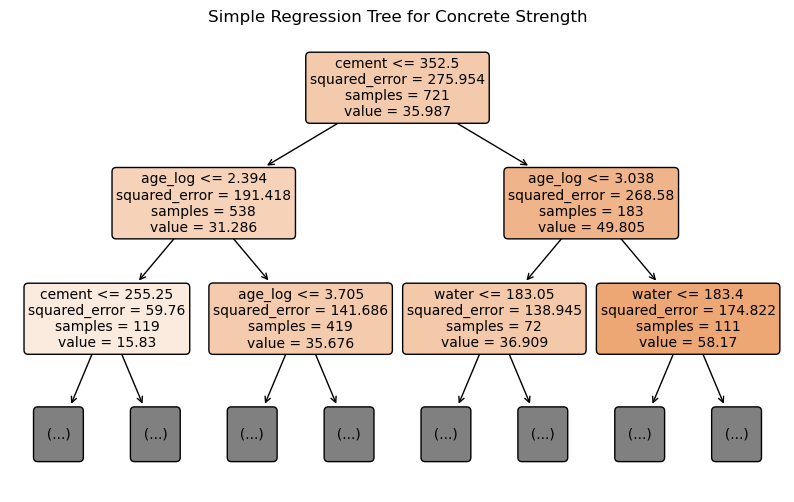

In [48]:
# Plot the simple tree model
plt.figure(figsize=(10, 6))
plot_tree(simple_tree,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=2)
plt.title("Simple Regression Tree for Concrete Strength")
plt.show()

In [50]:
path = simple_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = np.unique(path.ccp_alphas)

cv_fold = 5
treeCV = GridSearchCV(simple_tree, {'ccp_alpha': ccp_alphas},
                      cv=cv_fold, scoring='neg_mean_squared_error', n_jobs=-1)
treeCV.fit(X_train, y_train)
best_alpha_tree = treeCV.best_estimator_
best_alpha_id = treeCV.best_index_
best_alpha_score = treeCV.best_score_
best_alpha = treeCV.best_params_['ccp_alpha']
print(f"Optimal alpha: {best_alpha:.6f}")

Optimal alpha: 0.001519


In [52]:
# fit pruned tree and get error
pruned_tree = DecisionTreeRegressor(random_state=598, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

y_pred_train = pruned_tree.predict(X_train)
y_pred_test = pruned_tree.predict(X_test)

mse_train_pruned = mean_squared_error(y_train, y_pred_train)
mse_test_pruned = mean_squared_error(y_test,  y_pred_test)

print(f"Train MSE: {round(mse_train_pruned, 2)} Test MSE: {round(mse_test_pruned, 2)}")

Train MSE: 1.62 Test MSE: 63.08


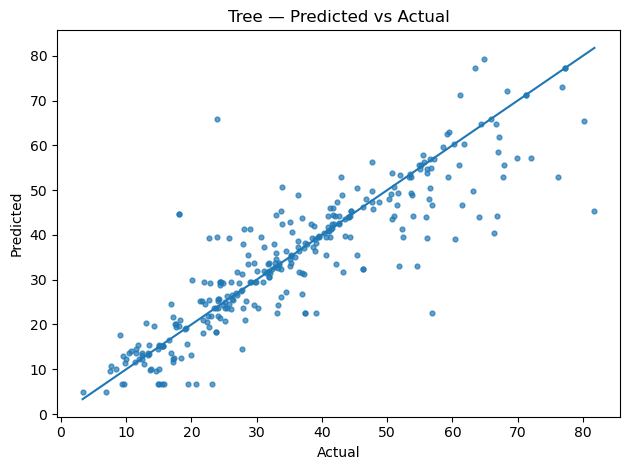

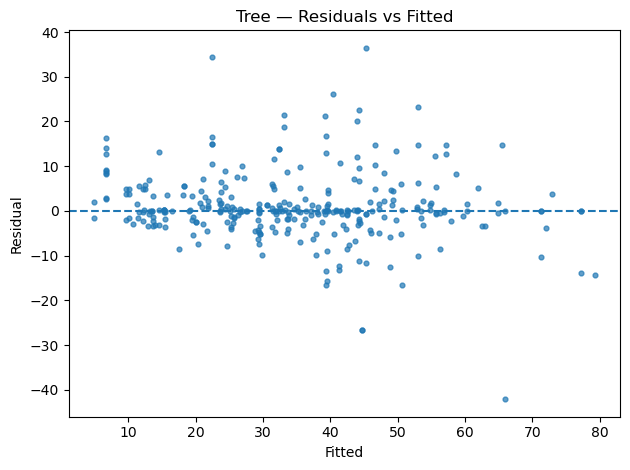

In [32]:
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'reports', 'figures')
plot_pred_vs_actual(y_test, y_pred_test, title='Tree — Predicted vs Actual', save_path=os.path.join(fig_dir, 'tree_pv.png'))
plot_residuals(y_test, y_pred_test, title='Tree — Residuals vs Fitted', save_path=os.path.join(fig_dir, 'tree_resid.png'))

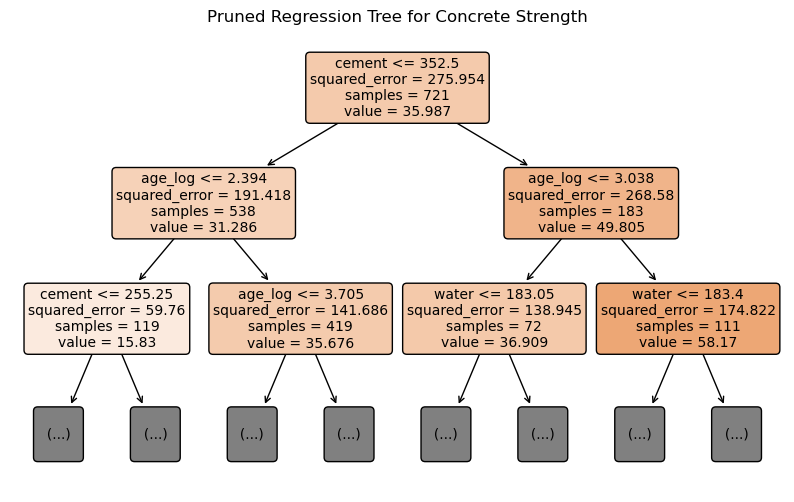

In [58]:
plt.figure(figsize=(10, 6))
plot_tree(pruned_tree,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=2)
plt.title("Pruned Regression Tree for Concrete Strength")
plt.show()

In [40]:
# Save Model Output
pd.DataFrame({"Model": ["Regression Tree"], "Test MSE": [mse_test_pruned]}).to_csv(os.path.join(fig_dir, 'tree_mse.csv'), index=False)